In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prysm import (
    coordinates,
    geometry,
    segmented,
    polynomials,
    propagation,
    wavelengths
)
from prysm.conf import config

# a convenient short-hand
WF = propagation.Wavefront

: 

## Load refractive index data

In [2]:
# Now set up the coatings
# Load the data Nasrat sent to us
def load_wl_n_k(material):
    pth = "/Users/jashcraft/Downloads/refractivedata/ag_mirror_model.xlsx"
    index_frame = pd.read_excel(pth)

    if material == 'SiO2':
        last = 201
    elif material == 'Ta2O5':
        last = 7
    elif material == 'Si3N4':
        last = 42
    elif material == 'NiCrO':
        last = 36
    elif material == 'Ag':
        last = 200
    elif material == 'BK7':
        last = 293

    wl = index_frame[f'Wavelength-{material}'][:last]
    n = index_frame[f'n-{material}'][:last]
    k = index_frame[f'k-{material}'][:last]

    # Create a spline of the data
    n_spline = interp1d(wl,n,kind='cubic')
    k_spline = interp1d(wl,k,kind='cubic')
    
    index = lambda wvl: n_spline(wvl) + 1j*k_spline(wvl)

    return index

f_SiO2 = load_wl_n_k('SiO2')
f_Ta2O5 = load_wl_n_k('Ta2O5')
f_Si3N4 = load_wl_n_k('Si3N4')
f_NiCrO = load_wl_n_k('NiCrO')
f_Ag = load_wl_n_k('Ag')
f_BK7 = load_wl_n_k('BK7')

## Load Rayfront

In [3]:
# Make sure to save it
from poke.writing import write_rayfront_to_serial,read_serial_to_rayfront
rf = read_serial_to_rayfront('/Users/jashcraft/Downloads/tfoptym_whitepaper/2048_ground_prototype.msgpack')

## Create TMT aperture

In [4]:
# update the surface with segment thickness, maybe a mask_rays() function?
diameter = np.max(rf.xData[0,0]) - np.min(rf.xData[0,0]) # assumption of rotational symmetry

# compose segmented
x, y = coordinates.make_xy_grid(2048, diameter=diameter)
dx = x[0,1] - x[0,0]

rings = 6
flat_to_flat_to_vertex_vertex = 2 / np.sqrt(3)
vtov_to_flat_to_flat = 1 / flat_to_flat_to_vertex_vertex

segdiam = vtov_to_flat_to_flat * 1.44
exclude = [
    0, 1, 2, 3, 4, 5, 6, # center
    469, 470, 508, 509, 507, 510, 506, 545,
    471, 511, 505, 544, 472, 397, 433, 546, # top, bottom
    534, 533, 532, 531, 521, 522, 523, 524, # left edge
    482, 483, 484, 485, 495, 494, 493, 492, # right edge
    457, 535, 445, 520, 481, 409, 421, 496, # corners
    536, 537, 479, 480, 497, 498, 519, 518, # next 'diagonal' from corners
]
cha = segmented.CompositeHexagonalAperture(x,y,13,segdiam,0.0025,exclude=exclude)


pupil_mask = cha.amp

def gen_segment_vars(ref_thickness,nmodes=4,pv_frac=0.02):

    nms = [polynomials.noll_to_nm(j) for j in range(nmodes+1)]
    cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.44/2);
    basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
    basis_coefs[:, 0] = np.random.uniform(-500, 500, 492)
    basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 492)
    basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 492)
    basis_coefs[:, 3:] = np.random.uniform(-1000, 1000, 492*(nmodes-2)).reshape((492,nmodes-2))
    # basis_coefs[:, :3] = 0

    phase_map = cha.compose_opd(basis_coefs)

    phase_map /= np.max(np.abs(phase_map))
    phase_map *= ref_thickness*pv_frac
    phase_map += ref_thickness

    return phase_map

<ipython-input-79-5e8111b33901>:7: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(gen_segment_vars(ref_thickness=8.5,nmodes=4,pv_frac=0.5)/pupil_mask,interpolation='none')


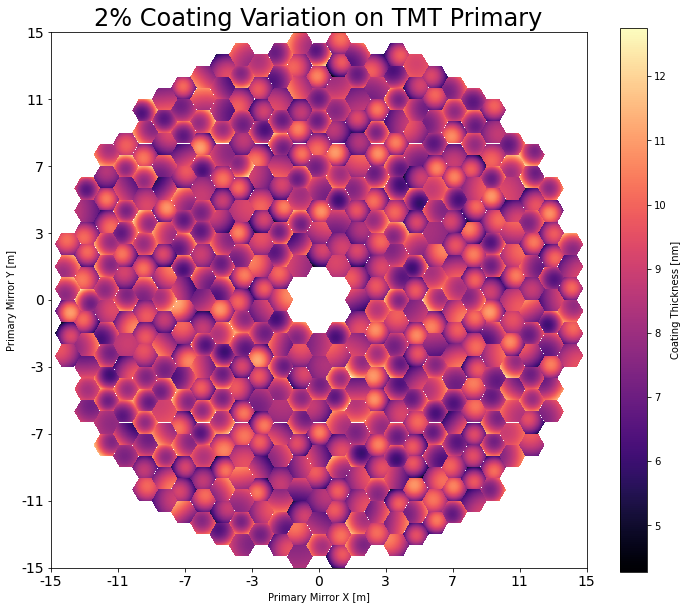

In [79]:
step = int(2048/8)
ticks = np.arange(0,2048+step,step)
tickstr = np.linspace(-15,15,len(ticks))
tickstr = [int(i) for i in tickstr]
plt.figure(figsize=[12,10])
plt.title('2% Coating Variation on TMT Primary',fontsize=24)
plt.imshow(gen_segment_vars(ref_thickness=8.5,nmodes=4,pv_frac=0.5)/pupil_mask,interpolation='none')
plt.colorbar(label='Coating Thickness [nm]')
plt.xticks(ticks,tickstr,fontsize=14)
plt.yticks(ticks,tickstr,fontsize=14)
plt.xlabel('Primary Mirror X [m]')
plt.ylabel('Primary Mirror Y [m]')
plt.show()

## Update the Rayfront surface list

In [196]:
def update_surflist(ncoat=1,nsurf=3,nmodes=4,wavelength=1000):

    rf.wavelength = wavelength
    surflist = []

    for i in range(nsurf):

        # apply coating variation
        if i == 0:
            segment_nonuniform = gen_segment_vars(ref_thickness=8.5,pv_frac=1e-9).ravel()
            protected_Ag = [
                (np.full_like(segment_nonuniform + 0*1j,f_Si3N4(wavelength)),segment_nonuniform),
                (np.full_like(segment_nonuniform + 0*1j,f_Ag(wavelength)))
            ]
        
        # apply base coating
        else:

            protected_Ag = [
                (np.full_like(segment_nonuniform + 0*1j,f_Si3N4(wavelength)),np.full_like(segment_nonuniform,8.5)),
                (np.full_like(segment_nonuniform + 0*1j,f_Ag(wavelength)))
            ]

        
        sN = {
            'coating':protected_Ag,
            'mode':'reflect'
        }

        surflist.append(sN)
    
    rf.surfaces = surflist
    if nsurf < 3:
        rf.compute_jones_pupil(aloc=np.array([0.,0.,1.]))
    else:
        rf.compute_jones_pupil(aloc=np.array([0.,-1.,0.]))


update_surflist(nsurf=3)


# Do the HCIPy Propagation

In [197]:
from hcipy import *
from poke.interfaces import jones_pupil_to_hcipy_wavefront
x = np.linspace(-1,1,2048)
x,y = np.meshgrid(x,x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r<1] = 1

<ipython-input-198-705e76090b9d>:12: RuntimeWarning: invalid value encountered in divide
  imshow_field(wvfnt.Q/pupil_mask.ravel())


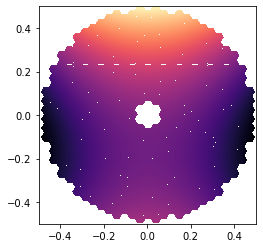

In [198]:
# Propagation grids
pupil_grid = make_pupil_grid(2048)
focal_grid = make_focal_grid(16,12)
prop = FraunhoferPropagator(pupil_grid,focal_grid)

# Make HCIPy wavefront
wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid)
aperture = make_circular_aperture(1)

# apply TMT aperture to jones elements
wvfnt.electric_field *= pupil_mask.ravel()
imshow_field(wvfnt.Q/pupil_mask.ravel())

In [291]:
jxx = wvfnt.electric_field[0,0]
jxy = wvfnt.electric_field[0,1]
jyx = wvfnt.electric_field[1,0]
jyy = wvfnt.electric_field[1,1]

common_phase = np.angle(jxx * np.conj(jyy))
dm_correction = np.exp(-1j*common_phase)
corrected_wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,input_stokes_vector=[1,0,0,0])
corrected_wvfnt.electric_field *= pupil_mask.ravel()
corrected_wvfnt.electric_field *= dm_correction

corrected_proxb = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,input_stokes_vector=[1,1,0,0])
corrected_proxb.electric_field *= pupil_mask.ravel()
corrected_proxb.electric_field *= dm_correction
corrected_proxb.electric_field *= np.exp(1j*2*np.pi * pupil_grid.x * 3)

In [292]:
# Set up a PerfectCoronagraph
tmt_aperture = make_tmt_aperture(True,with_spiders=False)
tmt = evaluate_supersampled(tmt_aperture,pupil_grid,1)

In [293]:
coro = PerfectCoronagraph(tmt,order=6)

In [272]:
# compute the PSFs
coro_psf = prop.forward(coro.forward(corrected_wvfnt))
coro_proxb = prop.forward(coro.forward(corrected_proxb))
coro_ref = prop.forward((corrected_wvfnt)).intensity#.max()

In [273]:
coro_ref.shape

(147456,)

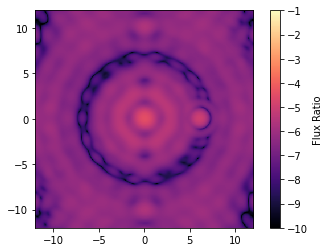

In [274]:
contrast_target = 1e-5
onaxis = coro_psf.intensity/coro_ref.max()
ofaxis = coro_proxb.intensity/coro_ref.max() * contrast_target
total_image = onaxis + ofaxis


plt.figure()
imshow_field(np.log10(total_image),vmin=-10,vmax=-1)
plt.colorbar(label='Flux Ratio')
plt.show()

In [294]:
from importlib import reload
import instruments
reload(instruments)
from instruments import double_different_pdi
coro_to_image = lambda w: prop(coro(w))
Q,U = double_different_pdi(corrected_wvfnt,corrected_proxb,coro_to_image,normalize=False,planet_contrast=1e-5)

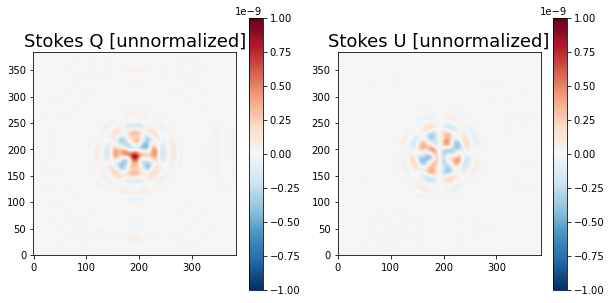

In [305]:
tol = 1e-9
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Stokes Q [unnormalized]')
plt.imshow(Q,vmin=-tol,vmax=tol,cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Stokes U [unnormalized]')
plt.imshow(U,vmin=-tol,vmax=tol,cmap='RdBu_r')
plt.colorbar()
plt.show()

## Compute Polarized Intensity v.s. Working Angle

In [345]:
# takes like 6 mins
working_angles = np.arange(12)
order = [2,4,6]
planet_contrast = 1e-5
I = np.empty([len(order),working_angles.shape[0],*Q.shape]) # polarized intensity

for i,q in enumerate(order):
    for j,angle in enumerate(working_angles):

        coro = PerfectCoronagraph(tmt,order=q)
        coro_to_image = lambda w: prop(coro(w))

        corrected_wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,input_stokes_vector=[1,0,0,0])
        corrected_wvfnt.electric_field *= pupil_mask.ravel()
        corrected_wvfnt.electric_field *= dm_correction
        corrected_wvfnt.electric_field *= 0

        corrected_proxb = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,input_stokes_vector=[1,1,0,0])
        corrected_proxb.electric_field *= pupil_mask.ravel()
        corrected_proxb.electric_field *= dm_correction
        corrected_proxb.electric_field *= np.exp(1j*2*np.pi * pupil_grid.x * angle)

        Q,U = double_different_pdi(corrected_wvfnt,corrected_proxb,coro_to_image,normalize=False,planet_contrast=planet_contrast)
        I[i,j] = np.sqrt(Q**2 + U**2)

In [369]:
# reference psf
I_reference = np.empty([len(order),*Q.shape])
for i,q in enumerate(order):

    coro = PerfectCoronagraph(tmt,order=q)
    coro_to_image = lambda w: prop(coro(w))
    corrected_wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,input_stokes_vector=[1,0,0,0])
    corrected_wvfnt.electric_field *= pupil_mask.ravel()
    corrected_wvfnt.electric_field *= dm_correction

    corrected_proxb = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,input_stokes_vector=[1,1,0,0])
    corrected_proxb.electric_field *= pupil_mask.ravel()
    corrected_proxb.electric_field *= dm_correction
    corrected_proxb.electric_field *= np.exp(1j*2*np.pi * pupil_grid.x * 0)
    Q,U = double_different_pdi(corrected_wvfnt,corrected_proxb,coro_to_image,normalize=False,planet_contrast=planet_contrast*1e-20)
    I_reference[i] = np.sqrt(Q**2 + U**2)

In [370]:
# compute azavgs of reference PSF
def radial_profile(data, center):
    """https://stackoverflow.com/questions/48842320/what-is-the-best-way-to-calculate-radial-average-of-the-image-with-python"""
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin #/ nr
    return radialprofile

ref_azavgs = []
for i in I_reference:
    pro = ref_azavgs.append(
        radial_profile(i,[384/2,384/2])
    )

<ipython-input-370-be99d71d31ce>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


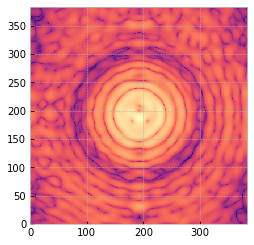

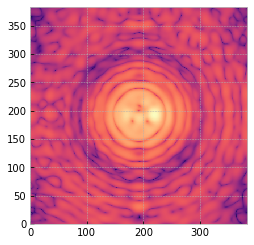

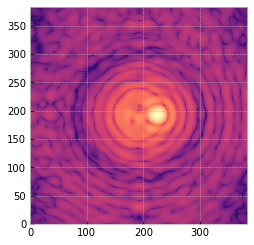

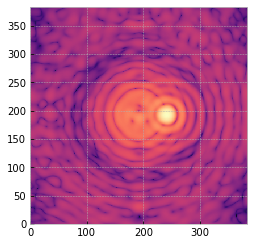

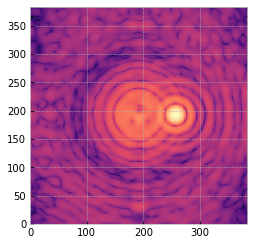

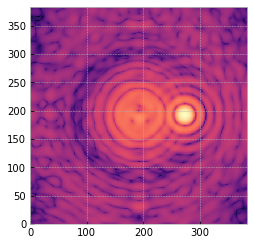

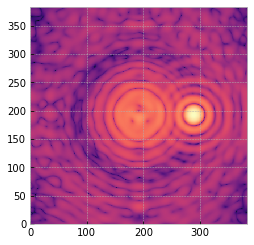

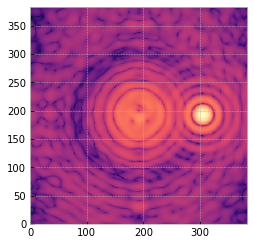

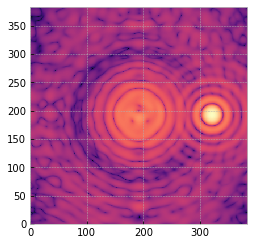

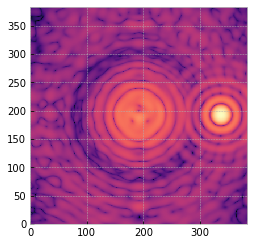

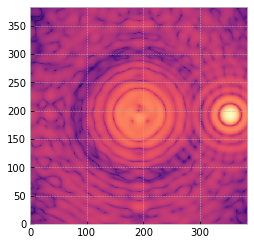

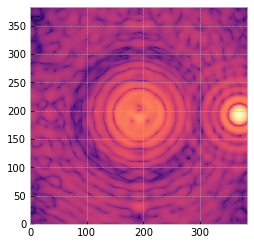

In [384]:
for i in I[2]:
    plt.figure()
    plt.imshow(np.log10(i + I_reference[2]))
    plt.show()

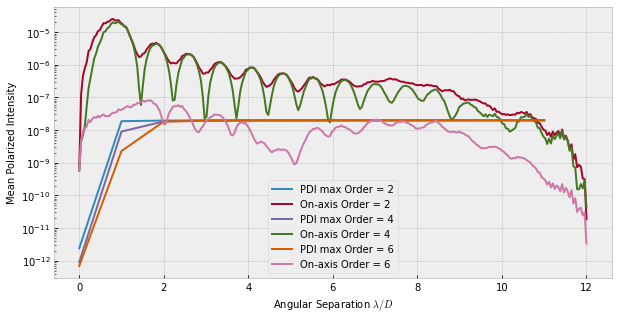

In [378]:
xaxis_high_sampled = np.linspace(0,12,ref_azavgs[0].shape[0])
pi_throughput = np.empty([len(order),working_angles.shape[0]])
for q in range(len(order)):
    for i in range(len(working_angles)):
        pi_throughput[q,i] = I[q,i].max()

plt.style.use('bmh')
plt.figure(figsize=[10,5])
for i,through in enumerate(pi_throughput):
    plt.plot(through,label=f'PDI max Order = {order[i]}')
    plt.plot(xaxis_high_sampled,ref_azavgs[i],label=f'On-axis Order = {order[i]}')
plt.ylabel('Mean Polarized Intensity')
plt.xlabel('Angular Separation '+r'$\lambda/D$')
plt.legend()
# plt.ylim([0,1e-7])
plt.yscale('log')
plt.show()

In [239]:
angle = 0
pbs = LinearPolarizingBeamSplitter(0)
im1,im2 = pbs(prop(corrected_wvfnt))
im1 = large_poisson(im1)
im2 = large_poisson(im2)
imshow_field(im1.power - im2.power)
plt.colorbar()

TypeError: '>' not supported between instances of 'Wavefront' and 'float'

In [354]:
Q.shape

(384, 384)

(2048, 2048, 2, 2)


<ipython-input-137-d159b9916ee7>:33: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(ret/pupil_mask)


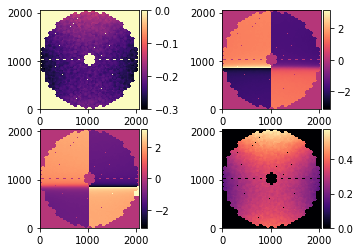

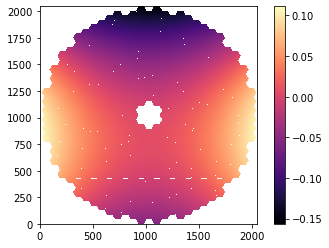

In [137]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_hcipy_jones_pupil(wvfnt):
    jxx = wvfnt.electric_field[0,0].shaped
    jxy = wvfnt.electric_field[0,1].shaped
    jyx = wvfnt.electric_field[1,0].shaped
    jyy = wvfnt.electric_field[1,1].shaped

    data = [jxx,jxy,jyx,jyy]
    fig,axs = plt.subplots(ncols=2,nrows=2)
    for d,ax in zip(data,axs.ravel()):

        im = ax.imshow(np.angle(d))
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="7%", pad="2%")
        fig.colorbar(im,cax=cax)


    return 

def plot_retardance(wvfnt):

    efield = wvfnt.electric_field.shaped
    efield = np.moveaxis(efield,-1,0)
    efield = np.moveaxis(efield,-1,0)
    print(efield.shape)
    evals = np.linalg.eigvals(efield)
    e1,e2 = evals[...,0],evals[...,1]
    ret = np.angle(e1)-np.angle(e2)
    ret -= np.mean(ret[pupil_mask==1])

    plt.figure()
    plt.imshow(ret/pupil_mask)
    plt.colorbar()
    plt.show()

plot_hcipy_jones_pupil(corrected_wvfnt)
plot_retardance(corrected_wvfnt)
    

(2048, 2048, 2, 2)


<ipython-input-137-d159b9916ee7>:33: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(ret/pupil_mask)


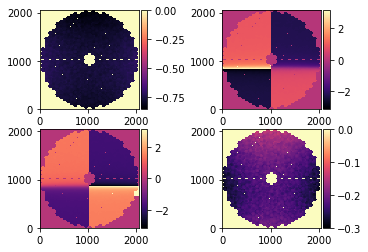

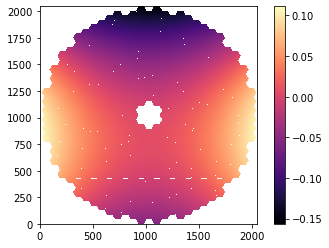

In [138]:
plot_hcipy_jones_pupil(wvfnt)
plot_retardance(wvfnt)

<ipython-input-142-755131c3f240>:3: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(dm_phase/pupil_mask,cmap='RdBu')


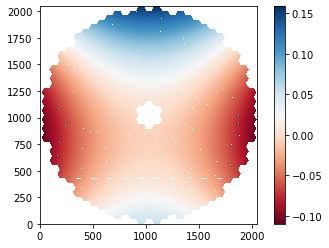

In [142]:
dm_phase = np.angle(dm_correction.shaped)
dm_phase -= np.mean(dm_phase[pupil_mask==1])
plt.imshow(dm_phase/pupil_mask,cmap='RdBu')
plt.colorbar()

In [128]:
help(np.linalg.eigvals)

Help on function eigvals in module numpy.linalg:

eigvals(a)
    Compute the eigenvalues of a general matrix.
    
    Main difference between `eigvals` and `eig`: the eigenvectors aren't
    returned.
    
    Parameters
    ----------
    a : (..., M, M) array_like
        A complex- or real-valued matrix whose eigenvalues will be computed.
    
    Returns
    -------
    w : (..., M,) ndarray
        The eigenvalues, each repeated according to its multiplicity.
        They are not necessarily ordered, nor are they necessarily
        real for real matrices.
    
    Raises
    ------
    LinAlgError
        If the eigenvalue computation does not converge.
    
    See Also
    --------
    eig : eigenvalues and right eigenvectors of general arrays
    eigvalsh : eigenvalues of real symmetric or complex Hermitian
               (conjugate symmetric) arrays.
    eigh : eigenvalues and eigenvectors of real symmetric or complex
           Hermitian (conjugate symmetric) arrays.
    sc

In [178]:
np.sqrt(147456)

384.0